# Import

In [17]:
# A rendre le vendredi 15 mars
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Exercice 1

In [7]:
DTC = DecisionTreeClassifier(max_depth=5)
GNB = GaussianNB()
KNC = KNeighborsClassifier(n_neighbors=1)

classifieurs = np.array([DTC, GNB, KNC])

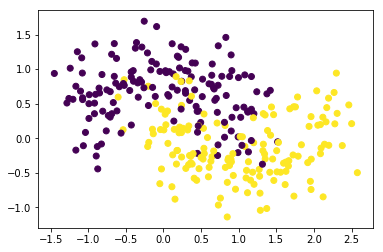

In [8]:
# génère des données synthétiques, deux classes sous formes de lunes
(Y,c) = make_moons(n_samples=300,noise=0.3, random_state=11)
plt.scatter(Y[:,0],Y[:,1],c=c)

In [9]:
def generer_plis(n,n_plis):
    plis = np.zeros(n)
    for i in range(n_plis):
        plis[n//n_plis*i:n//n_plis*(i+1)] = i
    return plis
plis = generer_plis(300,5)

In [11]:
# Calul du score de cross validation
n_classifieurs = 3
n_plis = 5

scores = np.zeros((n_plis, n_classifieurs))
for i in range(n_plis):
    for j in range(n_classifieurs):
        classifieurs[j].fit(Y[plis==i],c[plis==i])
        scores[i,j] = classifieurs[j].score(Y[plis!=i],c[plis!=i])
print(scores)

[[0.85       0.85       0.85416667]
 [0.79166667 0.83333333 0.8125    ]
 [0.82916667 0.84583333 0.82916667]
 [0.80833333 0.81666667 0.83333333]
 [0.80833333 0.85416667 0.82083333]]


In [12]:
def afficher(clf,X):
    h = .02
    x1_min, x1_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    x2_min, x2_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    x11, x22 = np.meshgrid(np.arange(x1_min, x1_max, h),np.arange(x2_min, x2_max, h))
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[x11.ravel(), x22.ravel()])
    else:
        Z = clf.predict(np.c_[x11.ravel(), x22.ravel()]).reshape(x11.shape)
    plt.contourf(x11, x22, Z, cmap=plt.cm.bwr, alpha=.8)

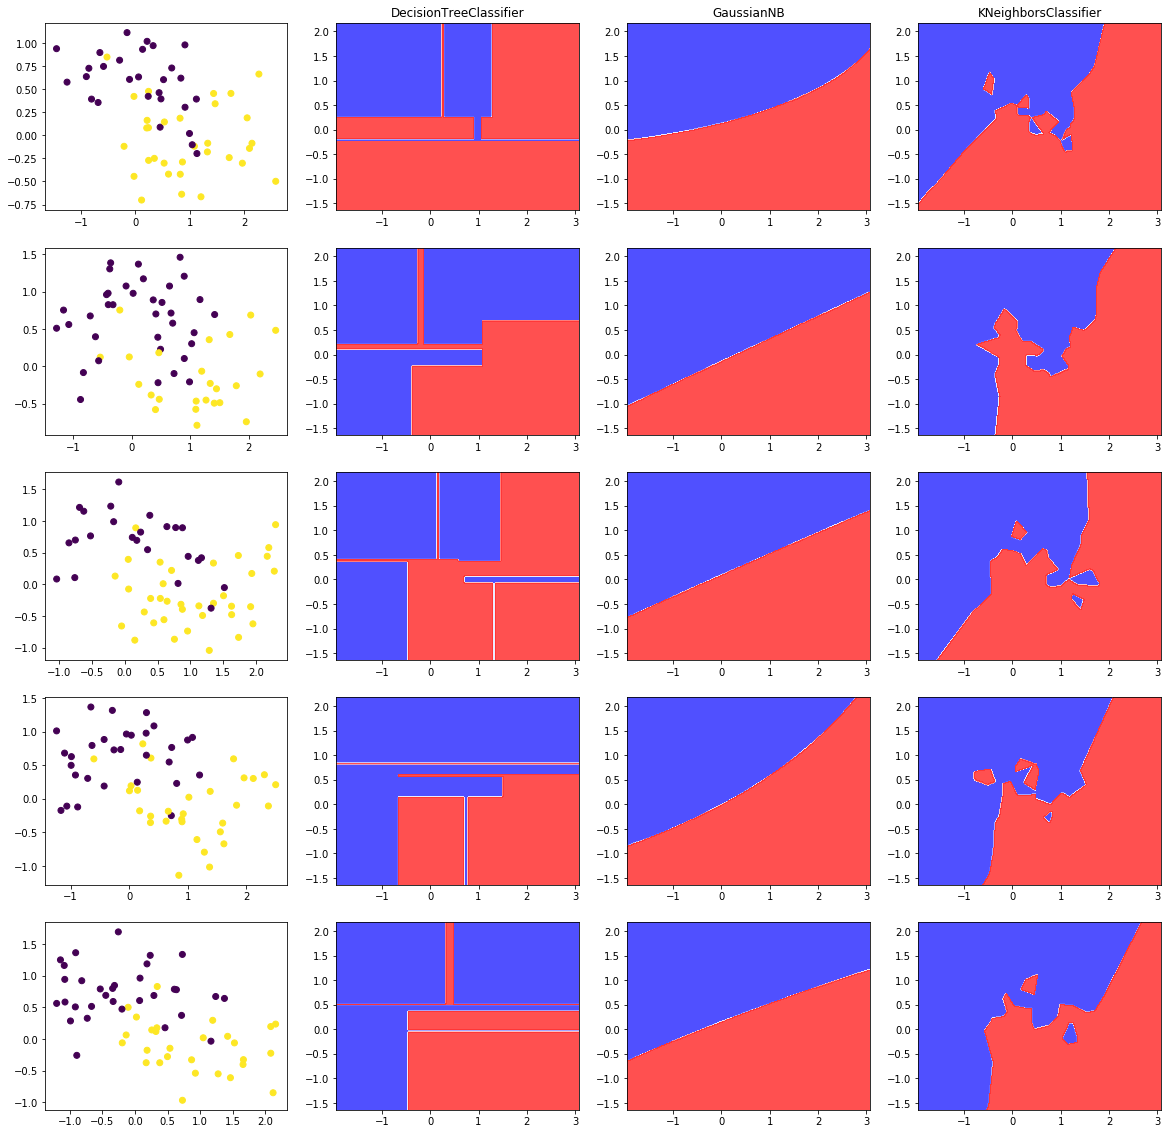

In [13]:
# Calul du score de cross validation
scores = np.zeros((n_plis, n_classifieurs))
plt.figure(figsize=(20,20))
for i in range(n_plis):
    plt.subplot(5, 4,np.ravel_multi_index((i,0),(5,4)) + 1)
    plt.scatter(Y[:,0][plis==i],Y[:,1][plis==i],c=c[plis==i])
    for j in range(n_classifieurs):
        classifieurs[j].fit(Y[plis==i],c[plis==i])
        plt.subplot(5, 4,np.ravel_multi_index((i,j+1),(5,4)) + 1)
        afficher(classifieurs[j], Y)
        if i == 0:
            plt.title(str(classifieurs[j]).split('(')[0])

In [14]:
class fusion_vote_maj_binary():
    def __init__(self, list_classifieur, is_train = False):
        self.list_class = list_classifieur
        self.n = len(list_classifieur)
        self.is_train = is_train
        
    def fit(self, X, y):
        if self.is_train:
            pass
        for i in range(self.n):
            self.list_class[i].fit(X, y)
        self.is_train = True
            
    def predict(self, X):
        assert self.is_train, "is not trained"
        prediction = np.zeros(X.shape[0])
        for clf in self.list_class:
            prediction += clf.predict(X)
        return ((prediction/self.n) > .5).astype(int)
    def score(self, X, y):
        return (self.predict(X)==y).mean()
        
        

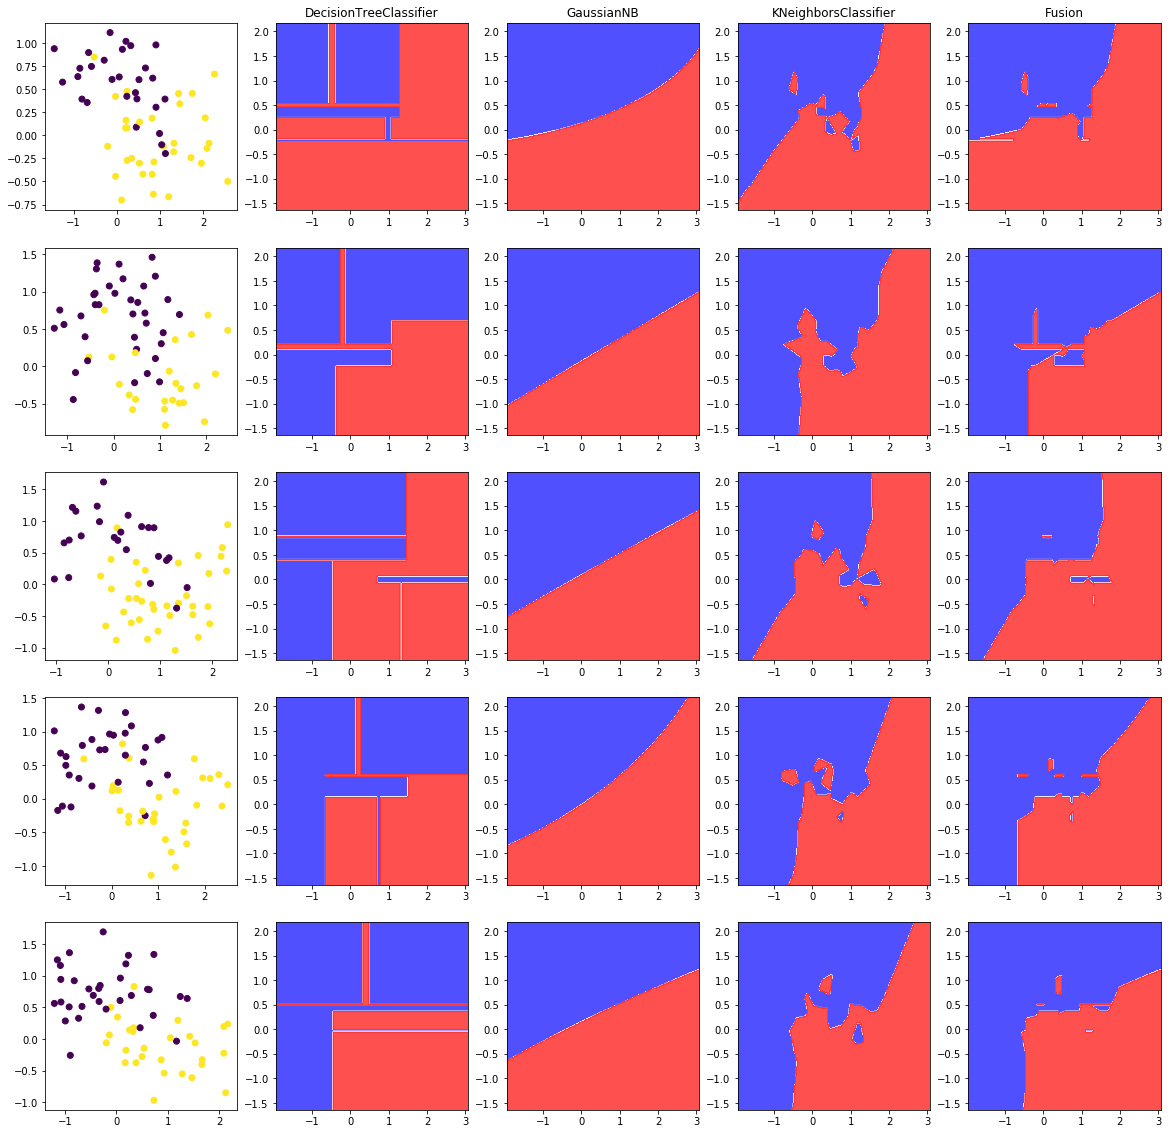

In [15]:
# Calul du score de cross validation
classifieurs = np.array([DTC, GNB, KNC])
scores = np.zeros((n_plis, n_classifieurs))
plt.figure(figsize=(20,20))
for i in range(n_plis):
    plt.subplot(5, 5,np.ravel_multi_index((i,0),(5,5)) + 1)
    plt.scatter(Y[:,0][plis==i],Y[:,1][plis==i],c=c[plis==i])
    for j in range(n_classifieurs):
        classifieurs[j].fit(Y[plis==i],c[plis==i])
        plt.subplot(5, 5,np.ravel_multi_index((i,j+1),(5,5)) + 1)
        afficher(classifieurs[j], Y)
        if i == 0:
            plt.title(str(classifieurs[j]).split('(')[0])
    FVM = fusion_vote_maj_binary(list(classifieurs), is_train=True)
    plt.subplot(5, 5,np.ravel_multi_index((i,4),(5,5)) + 1)
    afficher(FVM, Y)
    if i == 0:
            plt.title("Fusion")

## Q8.

In [21]:
# Calul du score, pour chaque classifieur entraîné 
# sur chaque pli, on calcule le score sur le dataset entier, privé du pli
# sur lequel on vient d'entraîner
n_classifieurs = 3

scores = np.zeros((n_plis, n_classifieurs+1))
for i in range(n_plis):
    for j in range(n_classifieurs):
        classifieurs[j].fit(Y[plis==i],c[plis==i])
        scores[i,j] = classifieurs[j].score(Y[plis!=i],c[plis!=i])
    FVM = fusion_vote_maj_binary(list(classifieurs), is_train=True)
    scores[i,3] = FVM.score(Y[plis!=i],c[plis!=i])
print(pd.DataFrame(scores,columns=["DTC","GNB","KNC","FVM"],index=[i+1 for i in range(5)]))

        DTC       GNB       KNC       FVM
1  0.816667  0.850000  0.854167  0.850000
2  0.791667  0.833333  0.812500  0.837500
3  0.833333  0.845833  0.829167  0.850000
4  0.800000  0.816667  0.833333  0.858333
5  0.808333  0.854167  0.820833  0.837500


En terme de score, la fusion par vote majoritaire est ici presque toujours plus performante. On le voit bien dans les frontières de décision, que la fusion montre une frontière qui serait plus proche de ce qu'un humain dessinerait naturellement. Elle fonctionne bien ici car chacun des classifieur simple capte des caractéristiques du dataset que les autres ne voient pas, et ils ont ainsi tous un avis complémentaire.

## Q9.

En changeant la seed, on change le dataset donc il est normal que la performance de la fusion ne soit pas la même.

## Q10.

Lorsqu'on a un classifieur qui est déjà bon tout seul, il y a peu de chance qu'on améliore sa performance en l'incluant dans un ensemble de classifieurs moins bons avec une méthode par vote majoritaire. En effet, si les classifieurs moins bons ne captent pas des caractéristiques du dataset qui seraient complémentaire aux caractéristiques trouvées par le réseau de neurones (ce qui est le cas ici), leur donner des voix de votes ne va faire que baisser le score.

In [22]:
from sklearn.neural_network import MLPClassifier
best_clf = MLPClassifier(hidden_layer_sizes=(100,35),activation='relu',alpha=1e-8)
for i in range(5):
    best_clf.fit(Y[plis==i],c[plis==i])
    print(best_clf.score(Y[plis!=i],c[plis!=i]))

/home/cindy/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cindy/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.8833333333333333
0.8708333333333333


/home/cindy/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cindy/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.8833333333333333
0.8916666666666667
0.8458333333333333


/home/cindy/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


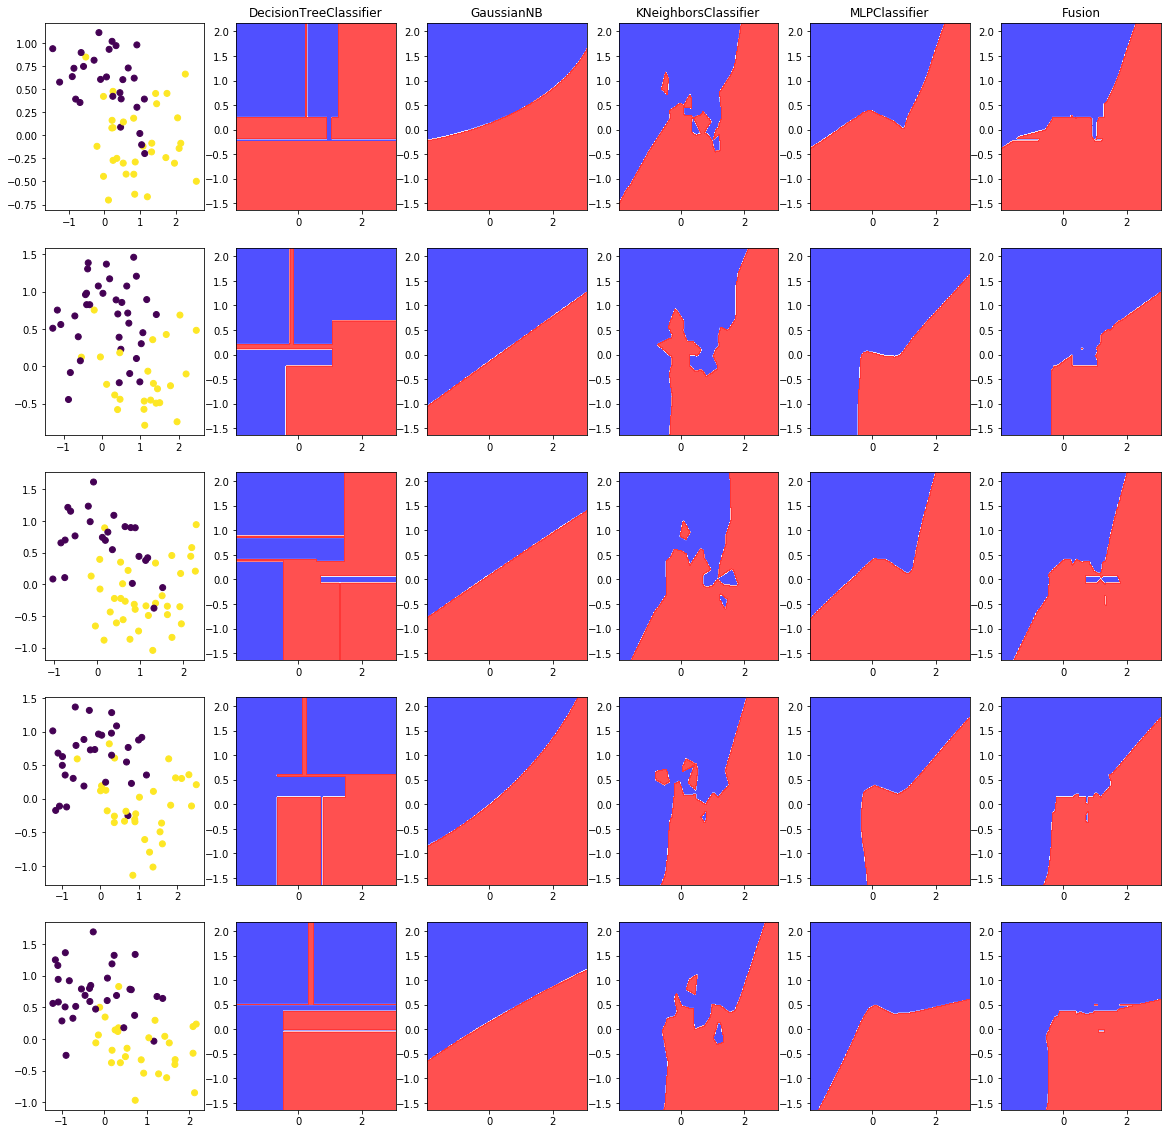

In [143]:
# Calul du score de cross validation
classifieurs = np.array([DTC, GNB, KNC,best_clf])
n_classifieurs = 4

scores = np.zeros((n_plis, n_classifieurs))
plt.figure(figsize=(20,20))
for i in range(n_plis):
    plt.subplot(5, 6,np.ravel_multi_index((i,0),(5,6)) + 1)
    plt.scatter(Y[:,0][plis==i],Y[:,1][plis==i],c=c[plis==i])
    for j in range(n_classifieurs):
        classifieurs[j].fit(Y[plis==i],c[plis==i])
        plt.subplot(5, 6,np.ravel_multi_index((i,j+1),(5,6)) + 1)
        afficher(classifieurs[j], Y)
        if i == 0:
            plt.title(str(classifieurs[j]).split('(')[0])
    FVM = fusion_vote_maj_binary(list(classifieurs), is_train=True)
    plt.subplot(5, 6,np.ravel_multi_index((i,5),(5,6)) + 1)
    afficher(FVM, Y)
    if i == 0:
            plt.title("Fusion")

In [24]:
# Calul du score de cross validation

scores = np.zeros((n_plis, n_classifieurs+1))
for i in range(n_plis):
    for j in range(n_classifieurs):
        classifieurs[j].fit(Y[plis==i],c[plis==i])
        scores[i,j] = classifieurs[j].score(Y[plis!=i],c[plis!=i])
    FVM = fusion_vote_maj_binary(list(classifieurs), is_train=True)
    scores[i,4] = FVM.score(Y[plis!=i],c[plis!=i])
print(scores)

IndexError: index 4 is out of bounds for axis 1 with size 4

In [150]:
# Comparer la variance des scores FVM avec celle des autres classifieurs

# Exercice 2

## Q1.

In [25]:
DTC = DecisionTreeClassifier(max_depth=5)
GNB = GaussianNB()
KNC = KNeighborsClassifier(n_neighbors=1)
DTC_faible = DecisionTreeClassifier(max_depth=1)


classifieurs = np.array([DTC, GNB, KNC, DTC_faible])

In [28]:
# Calul du score, pour chaque classifieur entraîné 
# sur chaque pli, on calcule le score sur le dataset entier, privé du pli
# sur lequel on vient d'entraîner

n_classifieurs = 4
scores = np.zeros((n_plis, n_classifieurs))
for i in range(n_plis):
    for j in range(n_classifieurs):
        classifieurs[j].fit(Y[plis==i],c[plis==i])
        scores[i,j] = classifieurs[j].score(Y[plis!=i],c[plis!=i])
print(pd.DataFrame(scores,
                   columns=["DTC","GNB","KNC","bad"],
                   index=[i+1 for i in range(5)]))

        DTC       GNB       KNC       bad
1  0.816667  0.850000  0.854167  0.808333
2  0.791667  0.833333  0.812500  0.662500
3  0.845833  0.845833  0.829167  0.808333
4  0.800000  0.816667  0.833333  0.754167
5  0.808333  0.854167  0.820833  0.791667


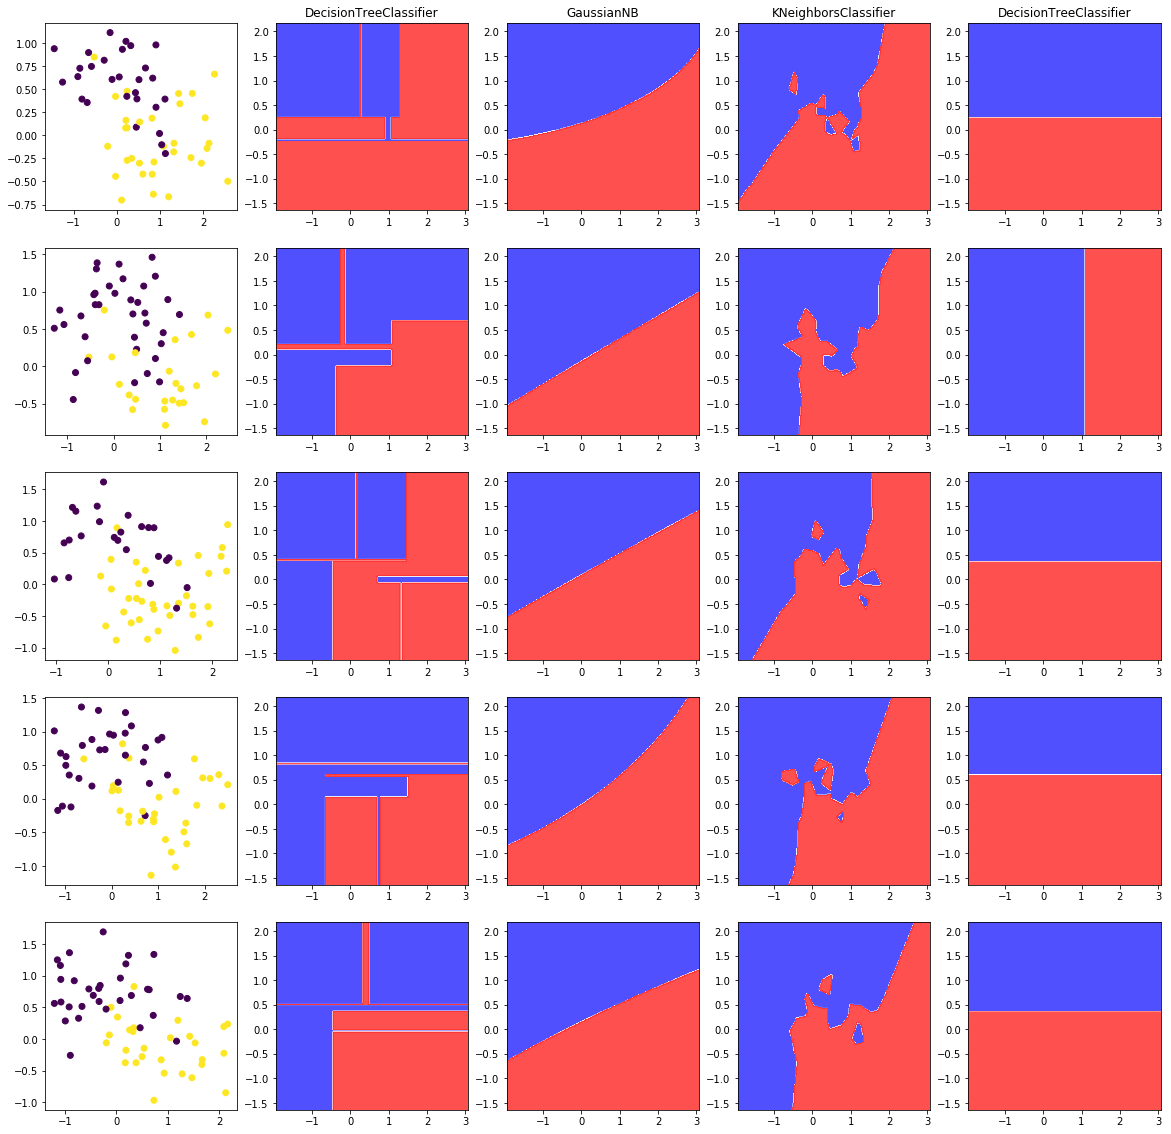

In [149]:
# Calul du score de cross validation
scores = np.zeros((n_plis, n_classifieurs))
plt.figure(figsize=(20,20))
for i in range(n_plis):
    plt.subplot(5, 5,np.ravel_multi_index((i,0),(5,5)) + 1)
    plt.scatter(Y[:,0][plis==i],Y[:,1][plis==i],c=c[plis==i])
    for j in range(n_classifieurs):
        classifieurs[j].fit(Y[plis==i],c[plis==i])
        plt.subplot(5, 5,np.ravel_multi_index((i,j+1),(5,5)) + 1)
        afficher(classifieurs[j], Y)
        if i == 0:
            plt.title(str(classifieurs[j]).split('(')[0])

## Q2.

In [ ]:
DTC = DecisionTreeClassifier(max_depth=5)
GNB = GaussianNB()
KNC = KNeighborsClassifier(n_neighbors=1)
DTC_faible = DecisionTreeClassifier(max_depth=1)


classifieurs = np.array([DTC, GNB, KNC, DTC_faible])

In [38]:
plis_2 = np.zeros(len(np.argwhere(plis==0)))
plis_2[len(plis_2)//2:]=1

dataset_plis_1 = Y[plis==4]
label_pli_1 = c[plis==4]

x_train = dataset_plis_1[plis_2==0]
x_val = dataset_plis_1[plis_2==1]
label_train = label_pli_1[plis_2==0]
label_val = label_pli_1[plis_2==1]

In [48]:
# Calul du score, pour chaque classifieur entraîné 
# sur chaque pli, on calcule le score sur le dataset entier, privé du pli
# sur lequel on vient d'entraîner

n_classifieurs = len(classifieurs)
w = np.zeros((n_plis, n_classifieurs))
for i in range(n_plis):
    for j in range(n_classifieurs):
        dataset_plis_1 = Y[plis==i]
        label_pli_1 = c[plis==i]
        
        x_train = dataset_plis_1[plis_2==0]
        x_val = dataset_plis_1[plis_2==1]
        label_train = label_pli_1[plis_2==0]
        label_val = label_pli_1[plis_2==1]
        
        classifieurs[j].fit(x_train,label_train)
        w[i,j] = classifieurs[j].score(x_val,label_val)
print(pd.DataFrame(w,
                   columns=["DTC","GNB","KNC","bad"],
                   index=[i+1 for i in range(5)]))

        DTC       GNB       KNC       bad
1  0.700000  0.833333  0.833333  0.833333
2  0.700000  0.833333  0.800000  0.733333
3  0.733333  0.833333  0.766667  0.733333
4  0.733333  0.766667  0.700000  0.600000
5  0.633333  0.933333  0.800000  0.833333


In [55]:
w = w.mean(axis=0)
print(pd.DataFrame(w.reshape((1,4)),
                   columns=["DTC","GNB","KNC","bad"]))

   DTC   GNB   KNC       bad
0  0.7  0.84  0.78  0.746667


## Q3.

## Q4.

In [60]:
def softmax(w,r=15):
    num = np.exp(r*w)
    return num/(num.sum())